# LetsGrowMore Virtual Internship Program

# LGMVIP-Data Science Internship-July-23

# By: Rajvi Mevada

# Task-3: Stock Market Prediction And Forecasting Using Stacked LSTM (Beginner level task)

### Probelm Statement
The objective of this project is to predict the closing stock price of Tata Global Beverages Ltd. for the next 28 days using a stacked LSTM neural network.

**Link for the dataset:** https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv

## LSTM neural network

Long Short-Term Memory Networks is a deep learning, sequential neural network that allows information to persist. It is a special type of Recurrent Neural Network which is capable of handling the vanishing gradient problem faced by RNN.

## Import necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [2]:
#checking my tensorflow version
tf.__version__

'2.12.0'

## Loading the Dataset

In [3]:
#Import the data and remove rows containing NAN values
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df=df. iloc[::-1]
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [4]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


## Data Preprocessing

In [5]:
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [6]:
df.shape

(2035, 8)

In [7]:
df.Date = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index = df['Date']
df.drop('Date', axis = 1,inplace = True)
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2010-07-21,122.10,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
...,...,...,...,...,...,...,...
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60


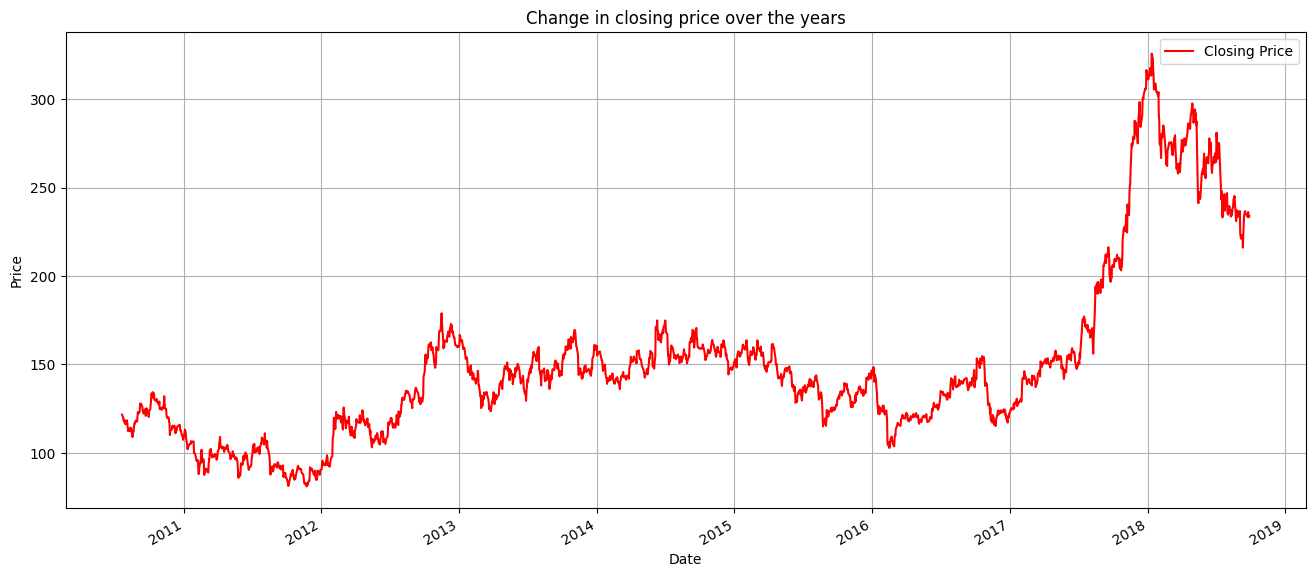

In [8]:
plt.figure(figsize=(10,6))
df['Close'].plot(kind='line',figsize=(16,7),color='r',label="Closing Price")

plt.ylabel("Price")
plt.legend(loc="upper right")
plt.title("Change in closing price over the years")
plt.grid()

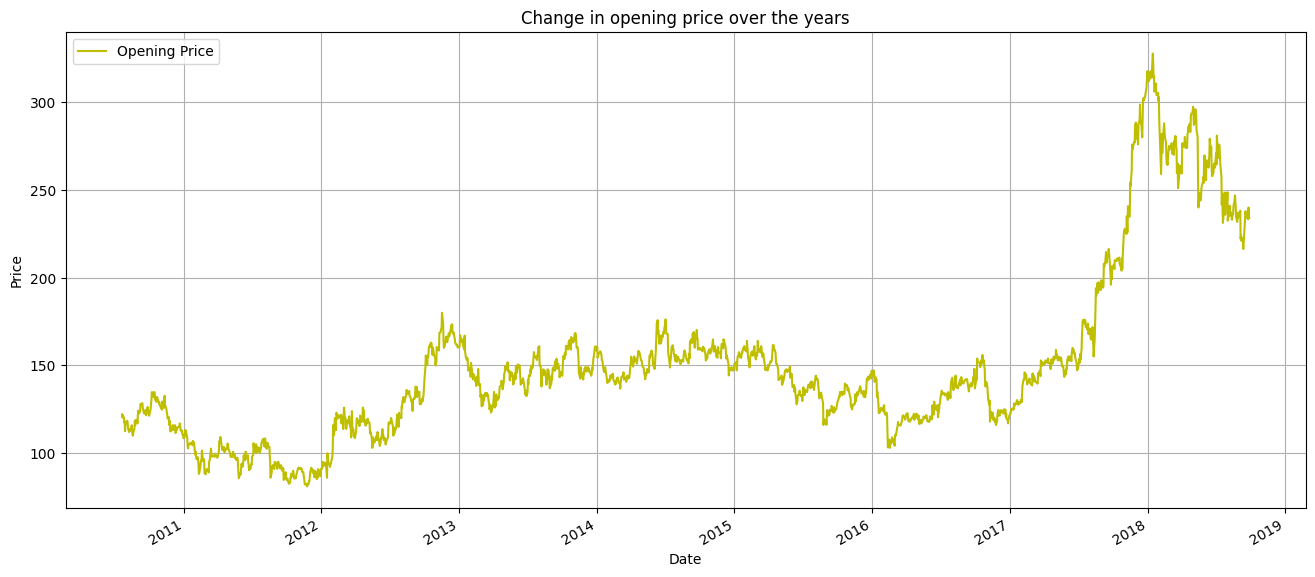

In [9]:
plt.figure(figsize=(10,6))
df['Open'].plot(kind='line',figsize=(16,7),color='y',label="Opening Price")

plt.ylabel("Price")
plt.legend(loc="upper left")
plt.title("Change in opening price over the years")
plt.grid()

<Axes: >

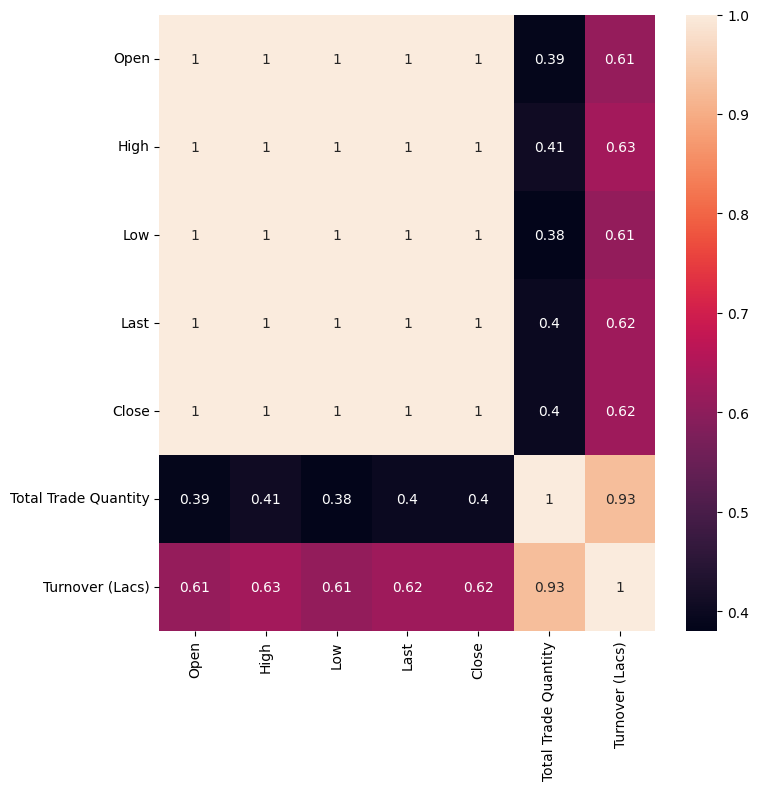

In [10]:
plt.figure(figsize = (8,8))
sns.heatmap(df.corr(), annot = True)

In [11]:
df_high=df.reset_index()['High']

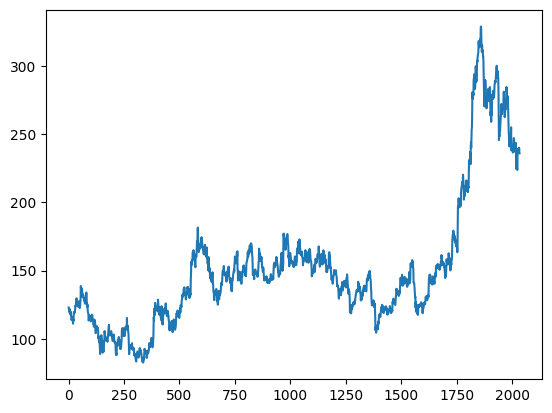

In [12]:
plt.plot(df_high)

**Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1**

In [13]:
scaler = MinMaxScaler(feature_range = (0,1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1,1))

In [14]:
df_high.shape

(2035, 1)

In [15]:
df_high

array([[0.16344786],
       [0.15938199],
       [0.15917869],
       ...,
       [0.6391543 ],
       [0.62614353],
       [0.62268754]])

In [16]:
#Split the data into train and test split
training_size = int(len(df_high) * 0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size,:], df_high[training_size:len(df_high),:1]

In [17]:
training_size,test_size

(1526, 509)

In [18]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [20]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [21]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [22]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

## Create the LSTM Model

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 75, batch_size = 64, verbose = 1)

Epoch 1/75
23/23 [==============================] - 35s 1s/step - loss: 0.0098 - val_loss: 0.0216
Epoch 2/75
23/23 [==============================] - 15s 636ms/step - loss: 0.0018 - val_loss: 0.0069
Epoch 3/75
23/23 [==============================] - 11s 504ms/step - loss: 8.5960e-04 - val_loss: 0.0032
Epoch 4/75
23/23 [==============================] - 13s 545ms/step - loss: 7.8509e-04 - val_loss: 0.0031
Epoch 5/75
23/23 [==============================] - 9s 412ms/step - loss: 7.9037e-04 - val_loss: 0.0033
Epoch 6/75
23/23 [==============================] - 10s 444ms/step - loss: 7.7419e-04 - val_loss: 0.0037
Epoch 7/75
23/23 [==============================] - 10s 446ms/step - loss: 7.3042e-04 - val_loss: 0.0066
Epoch 8/75
23/23 [==============================] - 10s 453ms/step - loss: 7.0643e-04 - val_loss: 0.0033
Epoch 9/75
23/23 [==============================] - 10s 441ms/step - loss: 6.3414e-04 - val_loss: 0.0042
Epoch 10/75
23/23 [==============================] - 10s 459ms/step

In [27]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [28]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

134.57703383438562

In [30]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

226.4533026950015

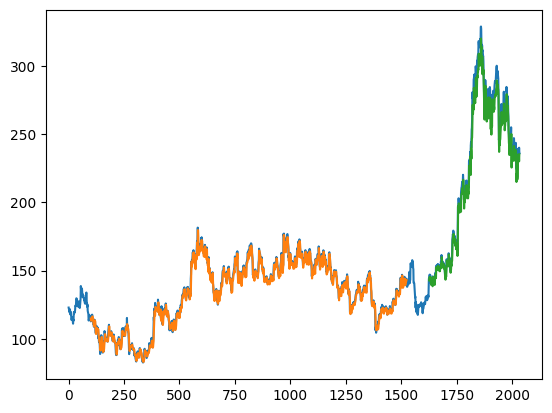

In [31]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_high) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

- Green indicates the Predicted Data
- Blue indicates the Complete Data
- Orange indicates the Train Data

### Predict the next 28 days Stock Price

In [32]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [33]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [35]:
lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):

    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.5985735]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 0

In [36]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [37]:
day_new.shape

(100,)

In [38]:
day_pred.shape

(28,)

In [39]:
df3 = df_high.tolist()
df3.extend(lst_output)

In [40]:
len(df_high)

2035

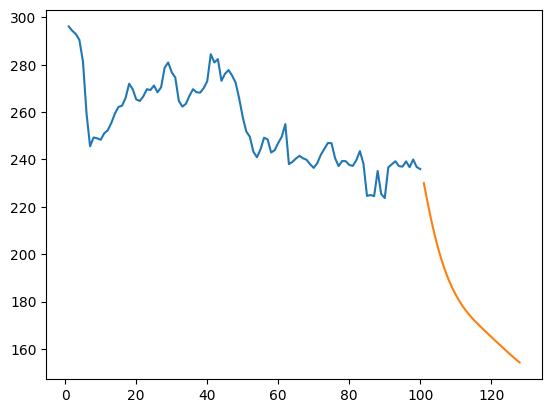

In [41]:
plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

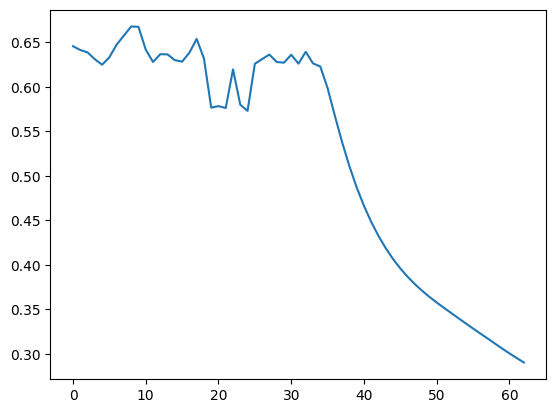

In [42]:
df3=df_high.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

In [43]:
df3=scaler.inverse_transform(df3).tolist()

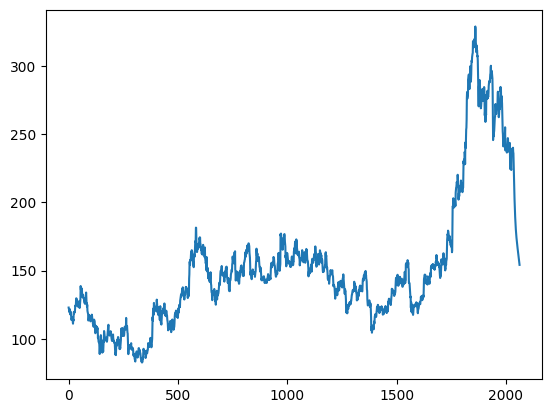

In [44]:
plt.plot(df3)